In [1]:
import os
os.chdir("/content/drive/MyDrive/DataScience/PROJECT/2022_Time_Series/time_series")

# read_data

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

In [4]:
pv.head()

,time,power,month,day,alt,azi,rad,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
datetime,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00-06:00,01/01/06 00,0.0,1,1,-82.519778,6.327078,0.0,17.6,15.9,90.0,0.0,NaN,130.0,5.4,NaN,1013.9,NaN,NaN
2006-01-01 01:00:00-06:00,01/01/06 01,0.0,1,1,-74.001270,66.094544,0.0,15.1,14.5,96.0,0.0,NaN,180.0,11.2,NaN,1014.7,NaN,NaN
2006-01-01 02:00:00-06:00,01/01/06 02,0.0,1,1,-61.530551,82.353403,0.0,15.1,14.5,96.0,0.0,NaN,200.0,11.2,NaN,1015.0,NaN,NaN
2006-01-01 03:00:00-06:00,01/01/06 03,0.0,1,1,-48.633108,91.048671,0.0,15.7,15.1,96.0,0.0,NaN,180.0,11.2,NaN,1014.9,NaN,NaN
2006-01-01 04:00:00-06:00,01/01/06 04,0.0,1,1,-35.752419,97.771663,0.0,15.7,15.1,96.0,0.0,NaN,170.0,9.4,NaN,1014.7,NaN,NaN


# decomposition

In [5]:
result = seasonal_decompose(pv['power'], freq=24)

<Figure size 432x288 with 0 Axes>

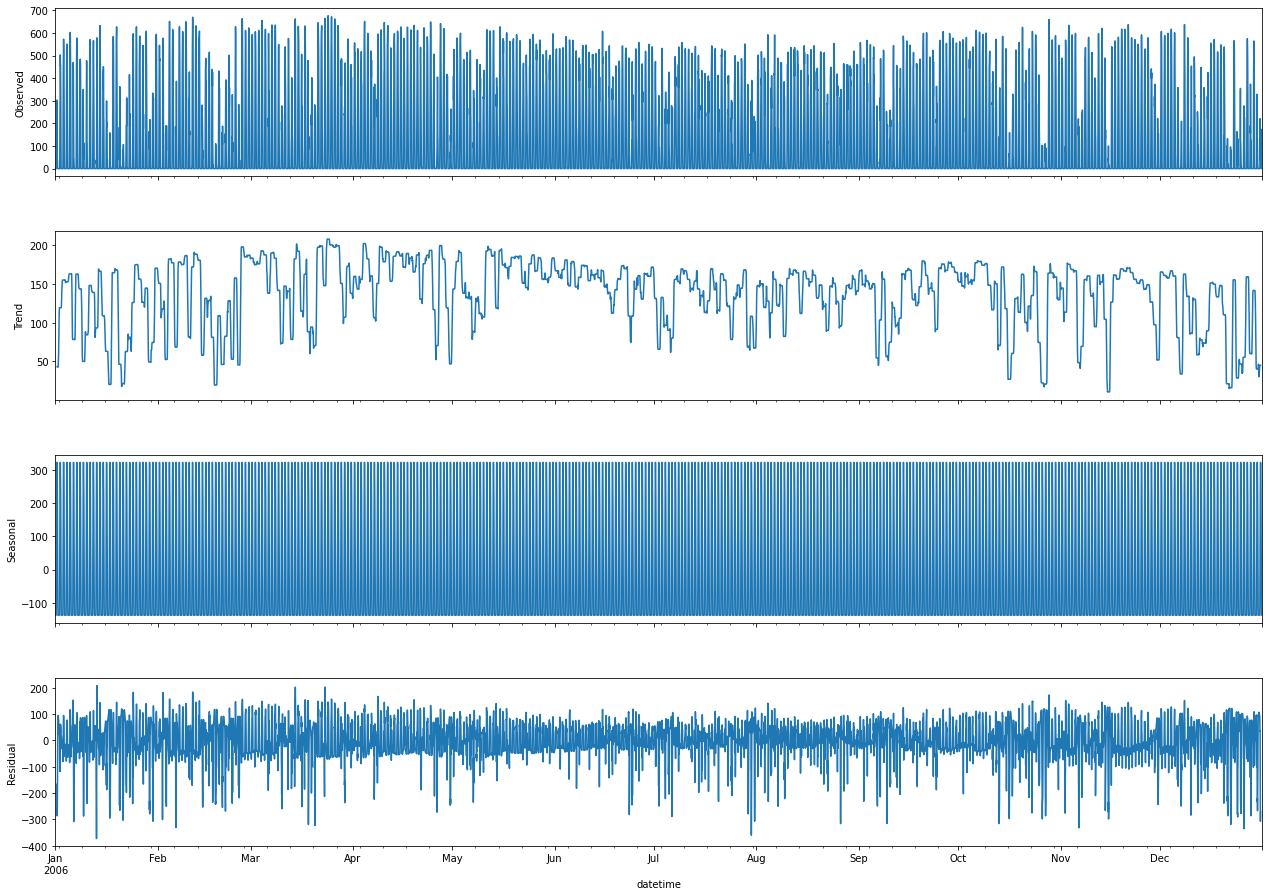

In [ ]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

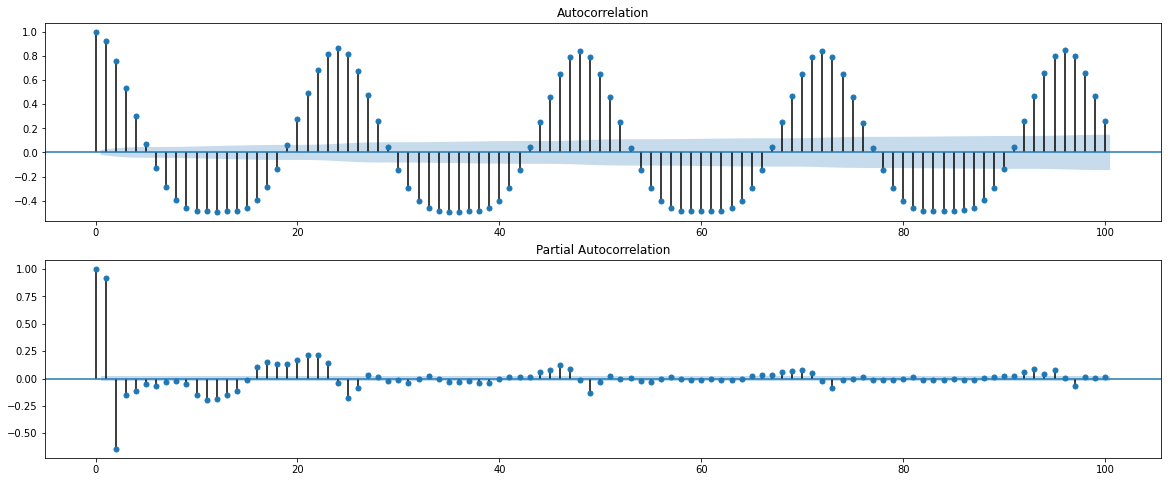

In [ ]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv['power'], lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv['power'], lags=100, ax=ax2)

# 24 주기로 seasonality

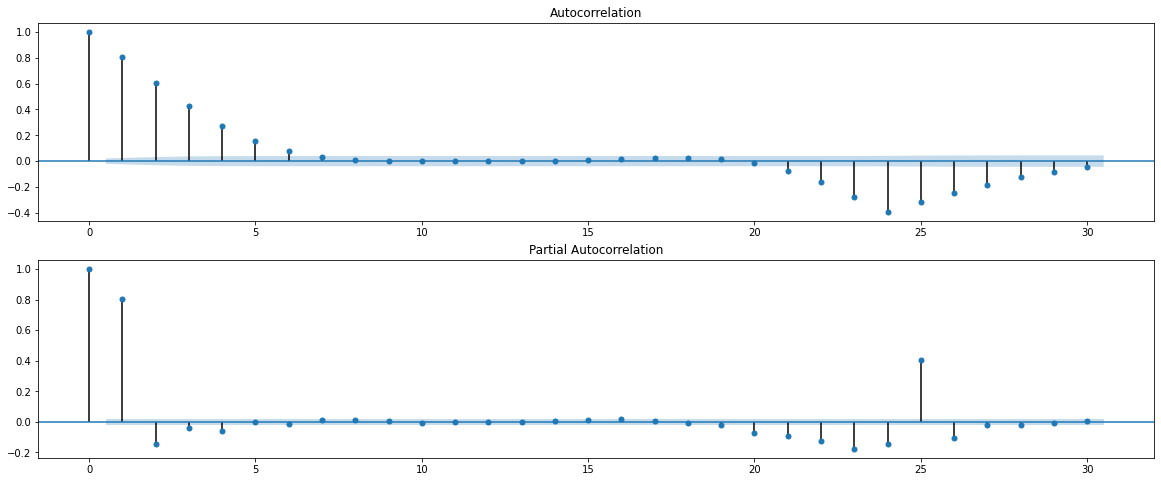

In [ ]:
pv['power_diff'] = pv['power'].diff(24)
pv_temp = pv['power_diff'].dropna()

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv_temp, lags=30, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv_temp, lags=30, ax=ax2)

# SARIMA & SARIMAX

p : pacf에서 수렴하기 직전값 -> 2

d : acf테스트 및 추세의 가시적 확인으로 추세여부 확인 -> 0

q : acf에서 수렴하기 직전값 -> 0

P : pacf에서 계절성이 주기가 몇 번 반복 됐는지 확인 -> 2

D : 계절성이 있는지 확인하고 계절성 차분의 필요성에 따라 1 or 0 -> 0

Q : acf기준 계절성 주기가 몇 번 반복 됐는지 확인 -> 5

m : 계절성 주기 -> 24



In [6]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,21,00,tzinfo=tz):]

In [7]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

In [9]:
for i in tqdm(range(11)):

    start = datetime(2006,12,21+i,00,tzinfo=tz)
    end = datetime(2006,12,21+i,23,tzinfo=tz)

    pv_train_temp = pv.loc[start - timedelta(hours=24*7):start - timedelta(hours=1)]
    pv_test_temp = pv.loc[start:end]

    model = SARIMAX(endog=pv_train_temp['power'], exog=None, order=[2,0,0], seasonal_order=[2,0,0,24])
    result = model.fit()

    pred = result.get_prediction(start=start, end=end, exog=None, dynamic=False)
    pv_test.loc[start:end, 'pred_mean'] = pred.predicted_mean.values

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, Value

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


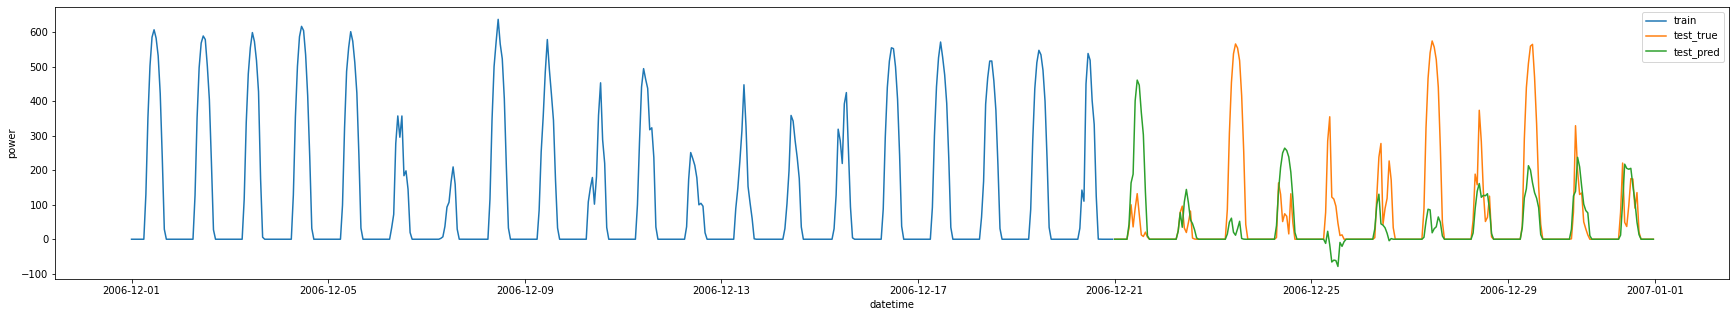

In [10]:
plt.figure(figsize=(30,5))

sns.lineplot(pv.loc[datetime(2006,12,1,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)].index, 
             pv.loc[datetime(2006,12,1,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz), 'power'], label='train')
sns.lineplot(pv_test.index, pv_test['power'], label='test_true')
sns.lineplot(pv_test.index, pv_test['pred_mean'], label='test_pred')
plt.legend()

In [11]:
print(f"test MSE: {mean_squared_error(pv_test['power'], pv_test['pred_mean']):.5f}")
print(f"test R2: {r2_score(pv_test['power'], pv_test['pred_mean']):.5f}")

test MSE: 19586.77713
test R2: -0.01516


# SARIMAX

In [12]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,21,00,tzinfo=tz):]

In [13]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

In [14]:
for i in tqdm(range(11)):

    start = datetime(2006,12,21+i,00,tzinfo=tz)
    end = datetime(2006,12,21+i,23,tzinfo=tz)

    pv_train_temp = pv.loc[start - timedelta(hours=24*7):start - timedelta(hours=1)]
    pv_test_temp = pv.loc[start:end]

    model = SARIMAX(endog=pv_train_temp['power'], exog=pv_train_temp[x_features], order=[2,0,0], seasonal_order=[2,0,0,24])
    result = model.fit()

    pred = result.get_prediction(start=start, end=end, exog=pv_test_temp[x_features], dynamic=False)
    pv_test.loc[start:end, 'pred_mean'] = pred.predicted_mean.values

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


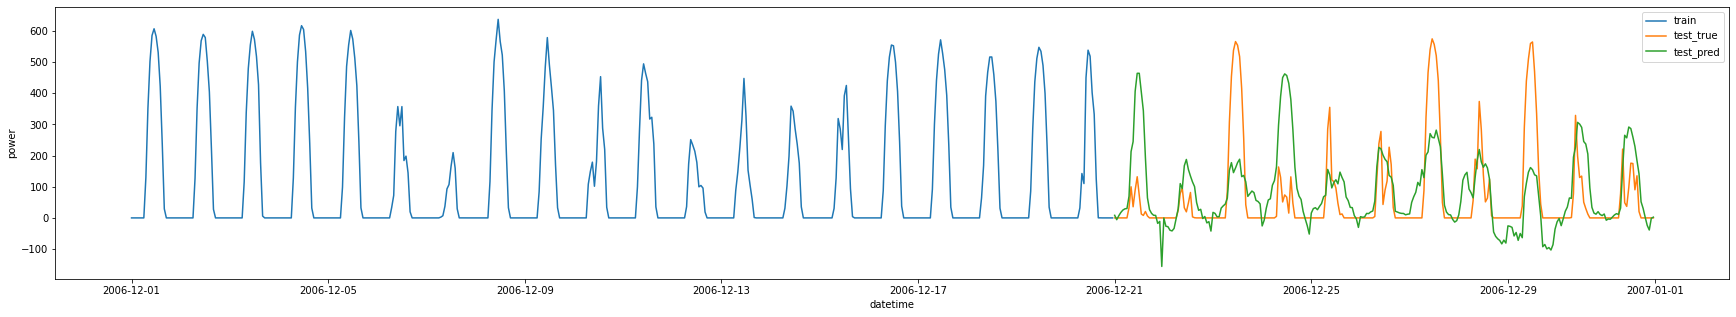

In [16]:
plt.figure(figsize=(30,5))

sns.lineplot(pv.loc[datetime(2006,12,1,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)].index, 
             pv.loc[datetime(2006,12,1,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz), 'power'], label='train')
sns.lineplot(pv_test.index, pv_test['power'], label='test_true')
sns.lineplot(pv_test.index, pv_test['pred_mean'], label='test_pred')
plt.legend()

In [17]:
print(f"test MSE: {mean_squared_error(pv_test['power'], pv_test['pred_mean']):.5f}")
print(f"test R2: {r2_score(pv_test['power'], pv_test['pred_mean']):.5f}")

test MSE: 18035.23926
test R2: 0.06526
